In [14]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import math

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.77it/s]


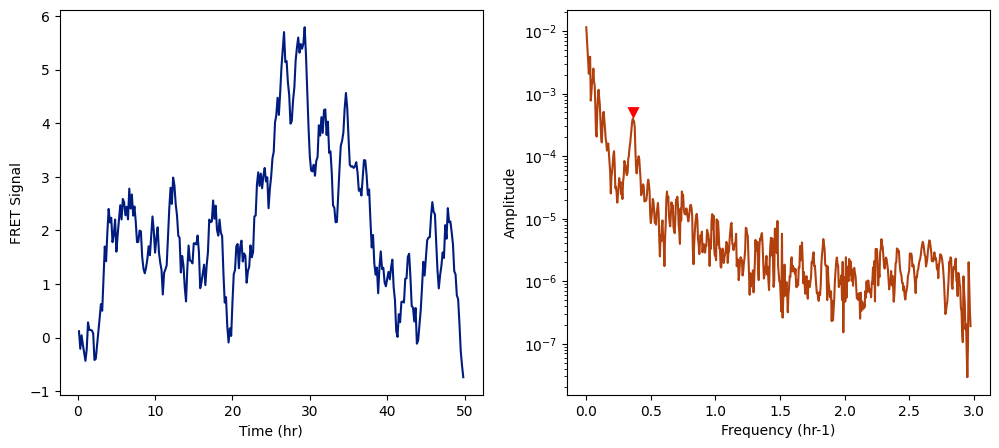

In [35]:
"""
This is a notebook that demonstrates the Expanding Window Fourier Transform.
"""

def blackman(y):
    a = [0.42,0.5,0.08]
    b = [a[0]-a[1]*np.cos(2*np.pi*x/len(y))+a[2]*np.cos(4*np.pi*x/len(y)) for x in y]
    return b

def pointer(df,x,y,points,ax):
    points = [min(df[x], key=lambda xx:abs(xx-poi)) for poi in points]
    df_ = df[df[x].isin(points)]
    df_ = df_[[x,y]].groupby([x],as_index=None).mean()
    df_[y] = [z+df_[y].mean()/4 for z in df_[y]]
    sns.scatterplot(data=df_,x=x,y=y,color='red',marker='v',s=100,ax=ax)

N = 300 #Number of time points. Each time point represents 10 minutes. 
wsize = int(N/2) #Smallest window size to transform. This is something you want to experiment with.
trunc = 0 #Truncation point. 0 if you want to evaluate over the whole time series.
sampling_freq = 6 #Rate that samples are taken. 6 samples/hour.
T = np.arange(N)/sampling_freq #Time bins.

### For demonstrative purposes we have generated a sine function with Brownian noise.
f = 0.36 #Sine function frequency
A = 0.2 #Sine function amplitude. 
trace = [0]
for i in range(1,N):
    trace.append(trace[i-1] + np.random.rand()-0.5 + A*np.sin(2*np.pi*f*T[i]))
df = pd.DataFrame({'time':T,'fret':trace,'fov':[1]*len(T)})
### 

df = df[df['time']>trunc]
df['time']-=trunc
nslide = int(df['time'].nunique()-wsize) #Number expansions to transform over. 
bins = np.arange(0,3,0.005) #Frequency bins to assign transform data to after all expansions. This is to your taste. 

#Perform Fourier transforms over all FOVs.
slide_dict = []
for i,df2 in tqdm(df.groupby(['fov'])):
    for j in range(nslide):
        df3 = df2.iloc[:wsize+j]
        ft = np.abs(np.fft.fft(blackman(df3['fret'])))**2 #Get squared modulus of the FFT. A Blackman window function is used.
        ft = ft[:math.floor(len(ft)/2)] #Retain half of the values due to symmetry around the Nyquist limit.
        fs = np.arange(len(ft))*(sampling_freq/(2*len(ft))) #Frequency bins
        slide_dict.append(pd.DataFrame({'frequency':fs,'amplitude':ft,'fov':[i]*len(ft)}))
fdf = pd.concat(slide_dict)

# Rebin with fewer frequencies.
binwidth = 0.005
bins = np.arange(0,sampling_freq/2,binwidth)
fourier_dict = []
for i, fdf2 in fdf.groupby(['fov']):
    for j in bins:
        fdf3 = fdf2[fdf2['frequency'].between(j,j+binwidth)]
        fourier_dict.append({'frequency':j,'amplitude':fdf3['amplitude'].mean(),'fov':i[0]})
fdf = pd.DataFrame(fourier_dict)

plt.rcParams["figure.figsize"]=12,5
sns.set_palette("dark")
fig, ax = plt.subplots(ncols=2)
sns.lineplot(data=df,x='time',y='fret',ax=ax[0],color=sns.color_palette()[0])
sns.lineplot(data=fdf,x='frequency',y='amplitude',ax=ax[1],color=sns.color_palette()[1])
ax[0].set_xlabel('Time (hr)')
ax[0].set_ylabel('FRET Signal')
ax[1].set_xlabel('Frequency (hr-1)')
ax[1].set_ylabel('Amplitude')
ax[1].set_yscale('log')
pointer(fdf,'frequency','amplitude',[f],ax[1])